### Import stuff

In [105]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import intake 
import pprint
import xesmf

In [3]:
import sys  
sys.path.insert(0, '/home/jupyter/InternalVariability/AdaptationAnalysis')

In [4]:
from app.main.src.climate_projection import ClimateProjection
from app.main.src.year_of_departure import *
from app.main.src.datasets import *
from app.main.src.post_processing import BiasCorrection, NoPostProcessing

### CMIP6 analysis for a single location

In [196]:
# set lat/lon
lat = 40
lon = -92

In [197]:
# get datasets via ClimateProjection workflow
# do monthly data first (using daily takes a while to load)
cp = ClimateProjection(
    lat=lat,
    lon=lon,
    variables=['t2m', 't2m_max', 't2m_min', 'tp'],    #TO-DO: figure out what the variables mean
    scenario='ssp585',
#     n_models=5,
    # projection_name='demo_midwest_new_pp',
    # gcs_bucket='climateai_data_repository',      #TO-DO: have this part explained again 
    # gcs_path='tmp/analog_test',
    # overwrite=False,
    daily=False
)

In [198]:
# load the data
#cross validate should always be false
cp.load(cross_validate=False,check_exist=False)

Computing None
No projection name given. No files will be saved.
No projection name given. No files will be saved.
No projection name given. No files will be saved.
No projection name given. No files will be saved.
No projection name given. No files will be saved.


some of the datasets that come out are raw_hist_monthly, reanalysis_monthly, pp_hist_monthly, pp_future-monthly

## Reproduce HS09
Here we will reproduce the model uncertainty and internal varaibility estimates using methodology from HS09 (i.e. fitting the data with a 4th order polynomial) 

### Prepare the data 

In [199]:
# inputs : raw or postprocessed 
input1 = cp.pp_hist_monthly
input2 = cp.pp_future_monthly

# input1 = cp.raw_hist_monthly
# input2 = cp.raw_future_monthly

In [200]:
# concat the post-processed historical and future datasets 
# resample yearly (AS = yearly resample at the beginning of the calendar year)
# drop models that do not have the t2m variable 
data = xr.concat(
    [input1, input2], dim='time'
).resample(time='AS').mean().t2m.dropna('model')

In [201]:
data

<xarray.DataArray 't2m' (time: 122, model: 14)>
array([[12.80702876, 10.8665568 , 11.4368751 , ..., 10.61267695,
        11.29070073, 11.91563082],
       [10.45318225, 12.05446122, 11.56253018, ..., 12.32510656,
        10.76854745, 11.736144  ],
       [11.52196175, 11.92011804, 12.88097297, ..., 11.63743896,
        11.37596178, 12.21003692],
       ...,
       [18.58469057, 18.25953482, 20.27516892, ..., 18.44978364,
        17.0302998 , 17.08717538],
       [19.81193865, 18.94265993, 20.33955448, ..., 17.2615938 ,
        17.11639865, 17.16640797],
       [19.73400534, 19.05688751, 19.41533316, ..., 18.05800872,
        15.8328444 , 17.06299653]])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2100-01-01
  * model    (model) <U16 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'MRI-ESM2-0' 'NESM3'
    lat      int64 40
    lon      int64 -92

In [202]:
# take a decadal rolling average and drop times
data = data.rolling(time=10, center=True).mean().dropna('time')

### Do the 4th order polynomial fit 

In [203]:
# create X and Y variables for the model fit 
X = np.arange(len(data.time))    # x variable is length of time
Y = data.values  # y is the temp data 

In [204]:
# the polynomial fit (4th order)
Z = np.polyfit(X,Y,4)

In [205]:
Z.shape   # why is this the shape of Z, is it because of the polynomial order?


(5, 14)

In [206]:
# make a copy of the data to do the fit using the coefs from Z 
fit = data.copy()

In [207]:
# is this a trick to avoid appending?? why isnt the m used in the for loop?
# what exactly are we doing here? Are we just constructing the fits for each of the models?
for i, m in enumerate(fit.model):
    p = np.poly1d(Z[:,i])
    fit[:, i] = p(X)

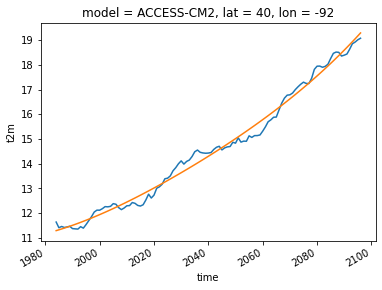

In [208]:
#plot a model and model fit 
data.isel(model=0).plot()
fit.isel(model=0).plot()

Text(0.5, 1.0, '4th Order Poly Fit of CMIP6 (raw, monthly) \n Temperature [Deg C] Projections for (lat,lon)=(40,-92)')

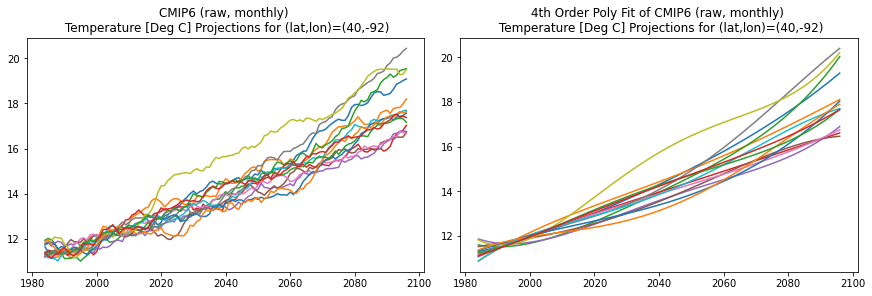

In [209]:
fig,ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(12,4))
for i in range(len(data.model)):
    ax[0].plot(data.time.dt.year,data.isel(model=i))
    ax[1].plot(fit.time.dt.year,fit.isel(model=i))
    
ax[0].set_title('CMIP6 (raw, monthly) \n Temperature [Deg C] Projections for (lat,lon)=(40,-92)')
ax[1].set_title('4th Order Poly Fit of CMIP6 (raw, monthly) \n Temperature [Deg C] Projections for (lat,lon)=(40,-92)')

#### calculate residual 

In [210]:
residual = data - fit 

In [211]:
internal = residual.var('time').mean('model')

In [212]:
model = fit.var('model')

Text(0.5, 1.0, 'CMIP6 Internal Variability for (lat,lon)=(-92,40)')

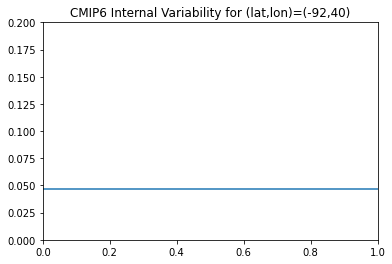

In [213]:
# model.plot()
plt.axhline(internal)
plt.ylim(0,0.2)
plt.title('CMIP6 Internal Variability for (lat,lon)=(-92,40)')

In [214]:
internal

<xarray.DataArray 't2m' ()>
array(0.04667259)
Coordinates:
    lat      int64 40
    lon      int64 -92

In [150]:
total = internal + model 

In [151]:
internal_frac = (internal/total)*100
model_frac = (model/total)*100

Text(0.5, 1.0, 'CMIP6 (post-processed, monthly) \n Fractional contribution to total uncertainty (%)')

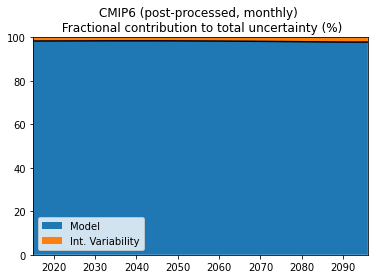

In [153]:
x = model_frac.time
y = model_frac
plt.fill_between(x,y,label='Model')
plt.plot(model_frac.time,model_frac,color='k')
plt.fill_between(x,y,100,label='Int. Variability')
plt.xlim(x[31],x[-1])
plt.ylim(0,100)
plt.legend(loc=3)
plt.title('CMIP6 (post-processed, monthly) \n Fractional contribution to total uncertainty (%)')

#### Look at global

In [159]:
lat = slice(None, None)
lon = slice(None, None)

In [160]:
lat

slice(None, None, None)

In [161]:
# get datasets via ClimateProjection workflow
# do monthly data first (using daily takes a while to load)
cp = ClimateProjection(
    lat=lat,
    lon=lon,
    variables=['t2m', 't2m_max', 't2m_min', 'tp'],   
    scenario='ssp585',
#     n_models=5,
    # projection_name='demo_midwest_new_pp',
    # gcs_bucket='climateai_data_repository',       
    # gcs_path='tmp/analog_test',
    # overwrite=False,
    daily=False
)

In [162]:
cp.load(cross_validate=False,check_exist=False,
        pp_method={'monthly' : {'t2m':BiasCorrection,
                                't2m_max':BiasCorrection,
                                't2m_min':BiasCorrection,
                                'tp':NoPostProcessing}},
       interp_dx=2.5)

Computing None
No projection name given. No files will be saved.
No projection name given. No files will be saved.
No projection name given. No files will be saved.
No projection name given. No files will be saved.
No projection name given. No files will be saved.


In [180]:
# inputs : raw or postprocessed 
# input1 = cp.pp_hist_monthly
# input2 = cp.pp_future_monthly

input1 = cp.raw_hist_monthly
input2 = cp.raw_future_monthly

In [181]:
data = xr.concat(
    [input1, input2], dim='time'
).resample(time='AS').mean().t2m.dropna('model')


In [182]:
# take a decadal rolling average and drop times
data = data.rolling(time=10, center=True).mean().dropna('time')

In [183]:
# global average 
data = data.mean(dim=('lon','lat'))

In [184]:
# create X and Y variables for the model fit 
X = np.arange(len(data.time))    # x variable is length of time
Y = data.values  # y is the temp data 

In [185]:
# the polynomial fit (4th order)
Z = np.polyfit(X,Y,4)

In [186]:
fit = data.copy()

In [187]:
for i, m in enumerate(fit.model):
    p = np.poly1d(Z[:,i])
    fit[:, i] = p(X)

Text(0.5, 1.0, '4th Order Poly Fit of CMIP6 (post-processed, monthly) \n Global Temperature [Deg C] Projections')

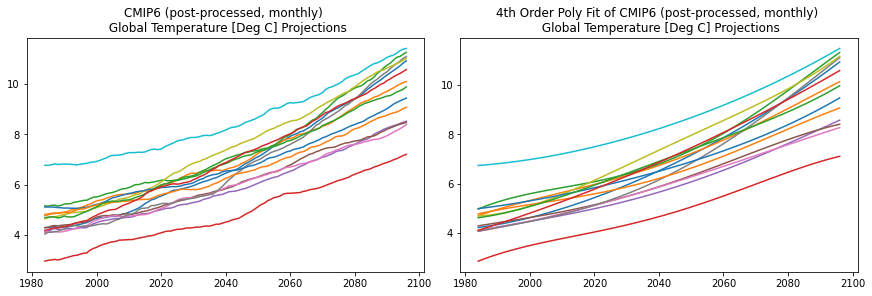

In [188]:
fig,ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(12,4))
for i in range(len(data.model)):
    ax[0].plot(data.time.dt.year,data.isel(model=i))
    ax[1].plot(fit.time.dt.year,fit.isel(model=i))
    
ax[0].set_title('CMIP6 (post-processed, monthly) \n Global Temperature [Deg C] Projections')
ax[1].set_title('4th Order Poly Fit of CMIP6 (post-processed, monthly) \n Global Temperature [Deg C] Projections')

In [189]:
residual = data - fit 

In [190]:
internal = residual.var('time').mean('model')

In [191]:
model = fit.var('model')

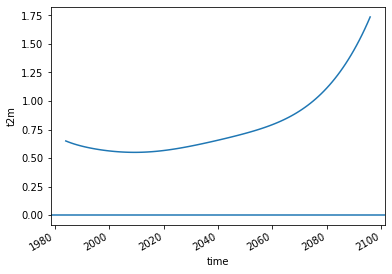

In [192]:
model.plot()
plt.axhline(internal)

In [193]:
total = internal + model 
internal_frac = (internal/total)*100
model_frac = (model/total)*100

Text(0.5, 1.0, 'CMIP6 (post-processed, monthly) \n Fractional contribution to total uncertainty (%)')

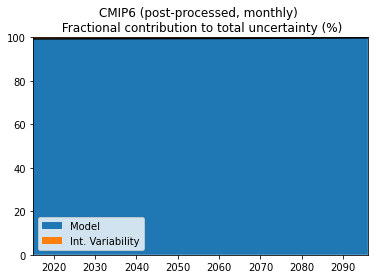

In [194]:
x = model_frac.time
y = model_frac
plt.fill_between(x,y,label='Model')
plt.plot(model_frac.time,model_frac,color='k')
plt.fill_between(x,y,100,label='Int. Variability')
plt.xlim(x[31],x[-1])
plt.ylim(0,100)
plt.legend(loc=3)
plt.title('CMIP6 (post-processed, monthly) \n Fractional contribution to total uncertainty (%)')

(0.0, 0.02)

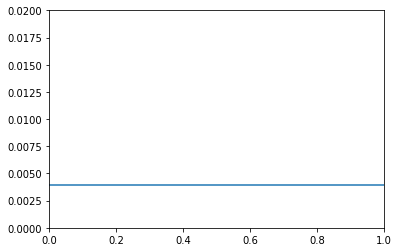

In [195]:
plt.axhline(internal)
plt.ylim(0,0.02)